In [1]:
import numpy,sys,matplotlib,pandas
import scanpy

scanpy.settings.verbosity = 3  
scanpy.logging.print_versions()

%matplotlib inline

scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
adata = scanpy.read_10x_mtx('/Volumes/omics4tb2/alomana/projects/i18/results/10x/aggregated/outs/filtered_feature_bc_matrix',var_names='gene_symbols',cache=True)
adata.var_names_make_unique() 

... reading from cache file cache/Volumes-omics4tb2-alomana-projects-i18-results-10x-aggregated-outs-filtered_feature_bc_matrix-matrix.h5ad


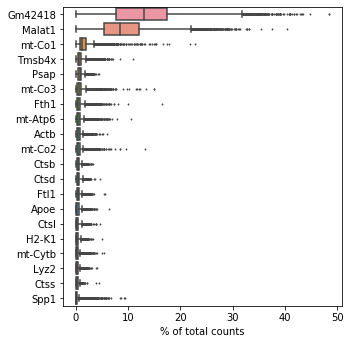

In [3]:
scanpy.pl.highest_expr_genes(adata, n_top=20)

In [4]:
scanpy.pp.filter_cells(adata, min_genes=200)
scanpy.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.obs` of view, making a copy.


filtered out 344 cells that have less than 200 genes expressed
filtered out 16854 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical


['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'] 13


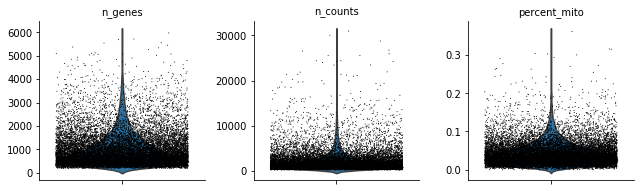

In [5]:
mito_genes=[element for element in adata.var_names if element[:2] == 'mt']
print(mito_genes,len(mito_genes))

adata.obs['percent_mito']=numpy.sum(adata[:,mito_genes].X,axis=1).A1/numpy.sum(adata.X,axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
scanpy.pl.violin(adata,['n_genes','n_counts','percent_mito'],jitter=0.4,multi_panel=True)

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


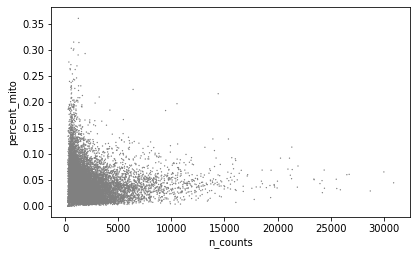

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


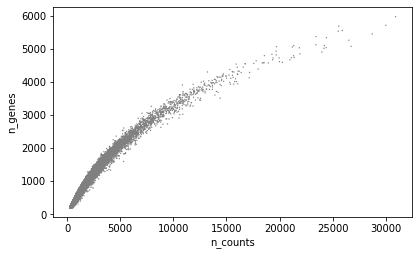

In [6]:
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [7]:
adata

AnnData object with n_obs × n_vars = 16541 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove high mito
View of AnnData object with n_obs × n_vars = 11485 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove top outliers
View of AnnData object with n_obs × n_vars = 11462 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove low n_count
View of AnnData object with n_obs × n_vars = 4356 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove low n_genes
View of AnnData object with n_obs × n_vars = 4355 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


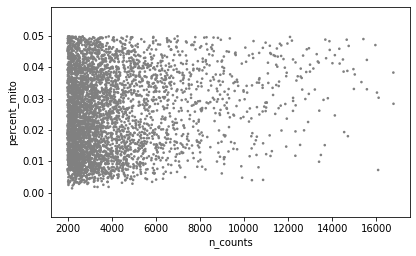

/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Users/alomana/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Users/alomana/anaconda3/lib/python3.7/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


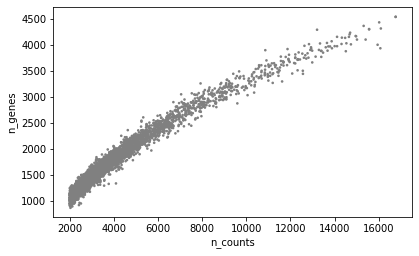

In [8]:
print('remove high mito')
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)
print()

print('remove top outliers')
adata = adata[adata.obs['n_counts'] < 17500, :] # NO, check no filtering
print(adata)
print()

print('remove low n_count')
adata = adata[adata.obs['n_counts'] > 2000, :] # 2 sd of the median
print(adata)
print()

print('remove low n_genes')
adata = adata[adata.obs['n_genes'] > 800, :] # 2 sd of the median
print(adata)
print()

scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [9]:
adata

AnnData object with n_obs × n_vars = 4355 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [10]:
scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=17e3)

In [11]:
scanpy.pp.log1p(adata)

In [12]:
adata.raw = adata

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


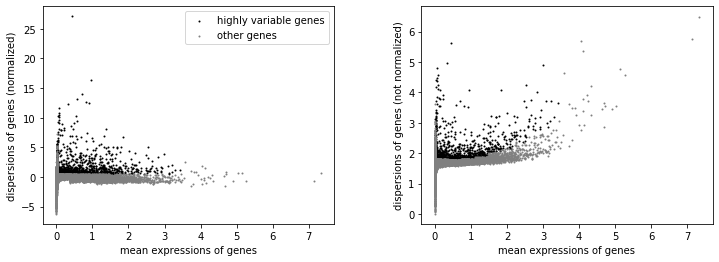

In [13]:
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3.5, min_disp=0.5)
scanpy.pl.highly_variable_genes(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 4355 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [15]:
sum(adata.var['highly_variable'])

1157

In [16]:
print(adata)
adata = adata[:,adata.var['highly_variable']]
print(adata)

AnnData object with n_obs × n_vars = 4355 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
View of AnnData object with n_obs × n_vars = 4355 × 1157 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [17]:
scanpy.pp.regress_out(adata,['n_counts','percent_mito']) # regress cell cyle!!!!

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.64)


In [18]:
scanpy.pp.scale(adata,max_value=10)

## 3. Visualization

In [19]:
scanpy.tl.pca(adata, svd_solver='arpack')


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.46)


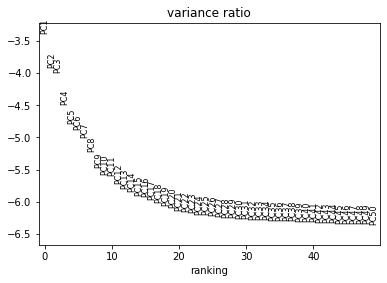

In [20]:
scanpy.pl.pca_variance_ratio(adata, log=True,n_pcs=50)


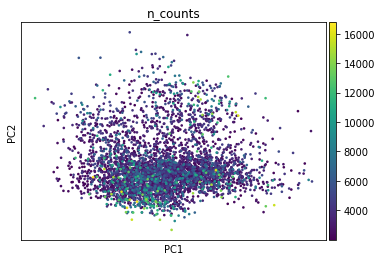

In [21]:
scanpy.pl.pca(adata,color='n_counts',palette='viridis')


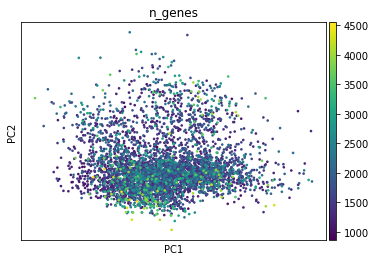

In [22]:
scanpy.pl.pca(adata,color='n_genes',palette='viridis')


In [23]:
scanpy.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:35.13) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


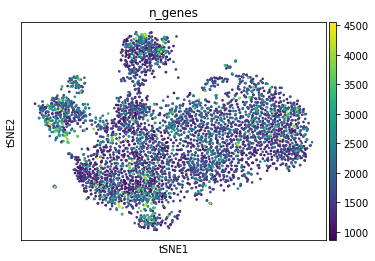

In [24]:
scanpy.pl.tsne(adata,color='n_genes',palette='viridis')

computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/alomana/anaconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back 

    finished (0:00:02.21) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:09.84) --> added
    'X_umap', UMAP coordinates (adata.obsm)


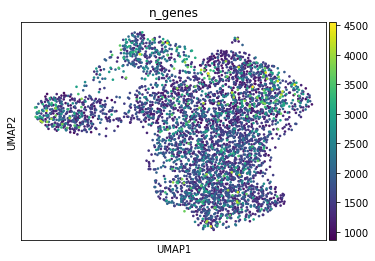

In [25]:
scanpy.pp.neighbors(adata, n_neighbors=50, n_pcs=50) # try 10 to 15 nei, from c lausted, 25 pcs
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color='n_genes',palette='viridis')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.87) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


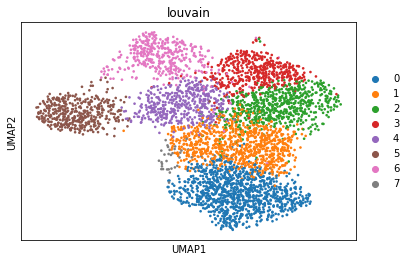

In [26]:
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata, color=['louvain'])

ranking genes
    finished (0:00:05.96) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


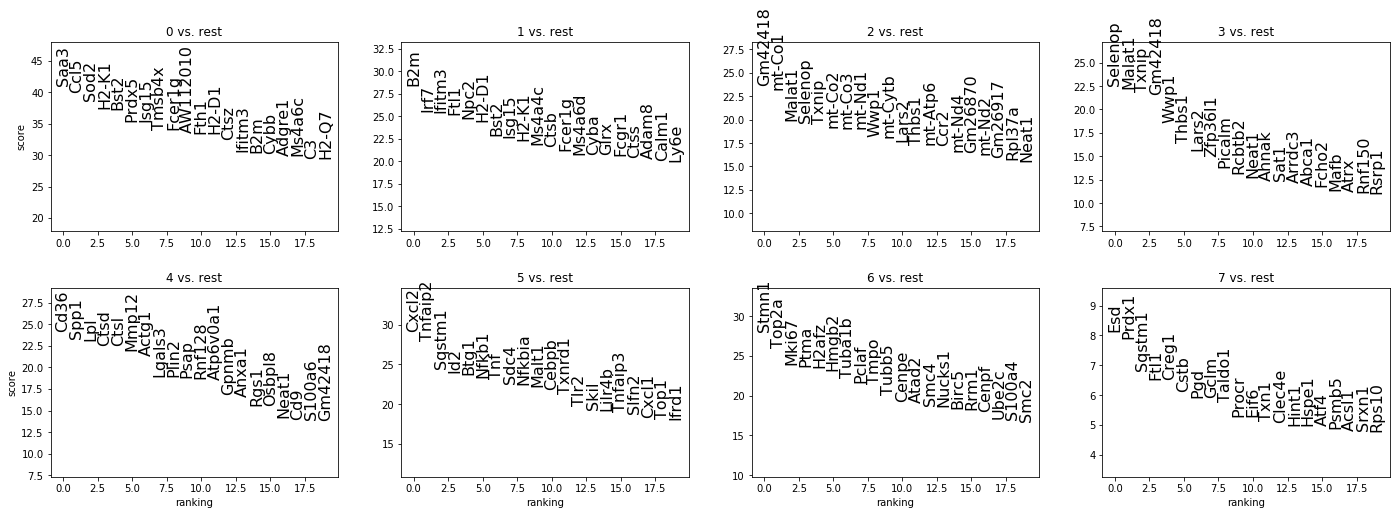

In [27]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=20, sharey=False,fontsize=16)

In [28]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(25)

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,4_l,5_n,5_p,5_l,6_n,6_p,6_l,7_n,7_p,7_l
0,Saa3,0.000000e+00,6.304311,B2m,2.840011e-173,1.237978,Gm42418,2.463611e-119,1.293614,Selenop,...,2.016794,Cxcl2,4.366855e-183,6.199902,Stmn1,1.628128e-169,5.355142,Esd,5.674603e-12,3.285814
1,Ccl5,0.000000e+00,5.190618,Irf7,2.719825e-140,1.963873,mt-Co1,3.503450e-115,0.695941,Malat1,...,2.631510,Tnfaip2,3.738867e-169,3.433466,Top2a,5.495572e-146,6.060942,Prdx1,2.087995e-11,2.551224
2,Sod2,0.000000e+00,3.690601,Ifitm3,1.431918e-138,1.741805,Malat1,6.797485e-85,0.649134,Txnip,...,1.785994,Sqstm1,1.434902e-128,2.647797,Mki67,2.819979e-123,5.830527,Sqstm1,4.554600e-08,2.765000
3,H2-K1,5.302521e-302,1.690701,Ftl1,1.684076e-136,0.782620,Selenop,8.409824e-83,1.711897,Gm42418,...,0.908540,Id2,3.054006e-124,2.965380,Ptma,4.918430e-120,1.520111,Ftl1,2.116239e-07,1.188744
4,Bst2,3.098417e-300,2.417160,Npc2,2.721623e-132,0.907059,Txnip,1.147897e-81,1.644755,Wwp1,...,1.711844,Btg1,2.665391e-121,2.439021,H2afz,1.275483e-118,2.788458,Creg1,2.116239e-07,1.722096
5,Prdx5,1.654923e-271,2.825443,H2-D1,3.588979e-128,1.089050,mt-Co2,1.396943e-78,0.812692,Thbs1,...,3.857162,Nfkb1,2.187346e-117,2.733204,Hmgb2,2.646309e-115,3.759279,Cstb,1.675436e-06,1.473012
6,Isg15,3.184193e-271,3.163718,Bst2,3.338277e-112,1.681284,mt-Co3,5.764285e-78,0.783776,Lars2,...,1.687508,Tnf,1.699916e-116,3.879020,Tuba1b,3.625202e-107,2.172717,Pgd,4.187176e-06,2.335141
7,Tmsb4x,7.212411e-251,1.103465,Isg15,1.272440e-110,2.263877,mt-Nd1,2.046524e-77,1.165655,Zfp36l1,...,1.269921,Sdc4,5.367772e-110,2.647938,Pclaf,3.398741e-101,5.785093,Gclm,4.187176e-06,3.695735
8,Fcer1g,1.881978e-250,2.018380,H2-K1,4.725774e-107,1.130833,Wwp1,4.944744e-71,1.554566,Picalm,...,1.329782,Nfkbia,3.922161e-108,2.760038,Tmpo,1.144983e-99,3.644386,Taldo1,6.930279e-06,2.056242
9,AW112010,3.802432e-245,3.502151,Ms4a4c,2.362542e-103,2.062460,mt-Cytb,2.426921e-70,1.061578,Rcbtb2,...,0.695479,Malt1,5.431399e-106,3.554402,Tubb5,9.656262e-87,2.300623,Procr,8.762713e-05,5.199064


ranking genes
    finished (0:00:00.79) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


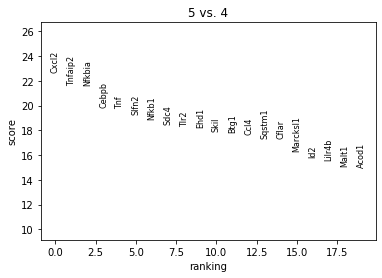

In [29]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['5'], reference='4', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['5'], n_genes=20)

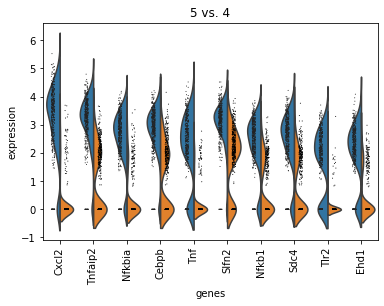

In [30]:
scanpy.pl.rank_genes_groups_violin(adata, groups='5', n_genes=10)